# **Overview - EuroSAT Image Classification**

**Implemented approach:**
1. Use ResNet50V2 pre-trained with imagenet weights, freeze layers and train the dense layer with a moderate learning rate
2. Unfreeze all layers and fine-tune the whole model end-to-end by keeping a small learning rate
3. For data preparation, instead of simply using RGB, use different indices (e.g. NDVI) to improve classification accuracy considering the 10 classes

# **Config**

In [1]:
import contextlib
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import pandas as pd
import rasterio as rio
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model
import torch

# Keras serves as the deep learning API used to train with ResNet50V2 (https://keras.io/api/)
from keras.applications import ResNet50V2
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

2024-05-12 17:14:46.158040: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-12 17:14:46.158171: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-12 17:14:46.417467: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# To always achieve the same results (reproducability), we specify a seed of 4216.
SEED_VALUE = 4216
np.random.seed(SEED_VALUE) # set numpy seed
torch.manual_seed(SEED_VALUE) # set pytorch seed CPU

# **Variables**
We define global variables for easier tweeking the model. Global variables are written in UPPERCASE in our notebook.

In [3]:
# Define all possible classes for the model
CLASSES = [
    "AnnualCrop", "Forest", "HerbaceousVegetation", "Highway", "Industrial",
    "Pasture", "PermanentCrop", "Residential", "River", "SeaLake",
]

In [91]:
"""
Global variables:
Location of training dataset
Location of official test dataset

split_percentage: size of the test split

batch size: how many samples are processed per step
width: width of the sample images
height: height of the sample images
dimensions: number of color channels in an sample image

epochs: number of epochs during training of the top layers
leaningrate: learning rate during training of the top layers

epochs_e2e: number of epochs during end to end training
learningrate_e2e: learning rate during end to end training
"""

EUROSAT_DIR = "/kaggle/input/eurosat/EuroSAT_MS/EuroSAT_MS"
TESTSET_DIR = "/kaggle/input/aiml-coding-challenge-fs24/testset/testset"

SPLIT_PERCENTAGE = 0.3
AUGMENTATION_PERCENTAGE = 0.3

BATCH_SIZE = 32
WIDTH = 64
HEIGHT = 64
DIMENSIONS = 3
INPUT_SHAPE = (WIDTH, HEIGHT, DIMENSIONS)

#MODEL
EPOCHS = 4
LEARNINGRATE = 0.001

EPOCHS_E2E = 18
LEARNINGRATE_E2E = 0.0001

# **Data Exploration**

In [34]:
"""
Loading of training data:
The file format for the training data is .tif

Loading of official test data:
The file format for the official test data is .npy
"""

train_samples = glob.glob(os.path.join(EUROSAT_DIR, "*", "*.tif"))
official_test_samples = glob.glob(os.path.join(TESTSET_DIR, "*.npy"))

print(f"Found {len(train_samples)} training samples.")
print(f"Found {len(official_test_samples)} test samples.")

Found 27000 training samples.
Found 4232 test samples.


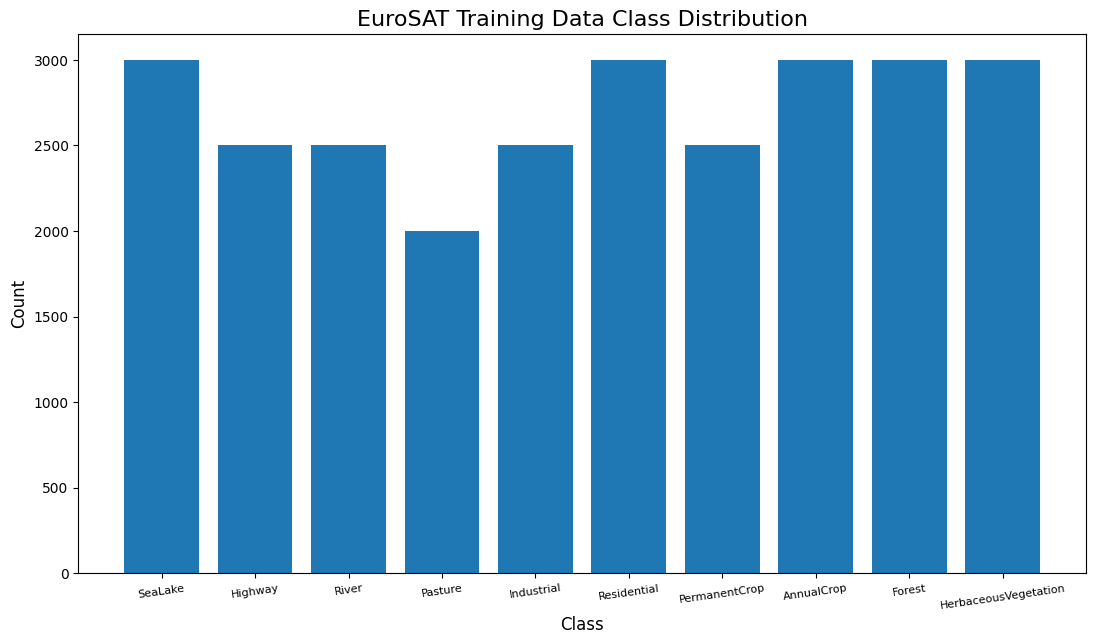

In [35]:
"""
Get an overview of the distribution of all training samples,
grouped by their labels.
"""

def get_folder_file_counts(dir):
    """Get the number of files in all subfolders of a given folder.
    
    Keyword arguments:
    dir -- the super folder 
    """
    folders = os.listdir(EUROSAT_DIR)
    folder_file_counts = {}
    for folder in folders:
        try:
            folder_path = os.path.join(dir, folder)
            file_count = len([name for name in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, name))])
            folder_file_counts[folder] = file_count
        except Exception as e:
            pass
    return folder_file_counts

file_counts_per_folder = get_folder_file_counts(EUROSAT_DIR)
plt.figure(figsize=(13, 7))
plt.bar(range(len(file_counts_per_folder)), list(file_counts_per_folder.values()), align="center")
plt.xticks(range(len(file_counts_per_folder)), list(file_counts_per_folder.keys()), fontsize=8, rotation=8)
plt.xlabel("Class", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("EuroSAT Training Data Class Distribution", fontsize=16);
plt.show()

In [36]:
# Also display the distribution in a tabular form.
df = pd.DataFrame(list(file_counts_per_folder.items()), columns=["Class", "Count"])
print(df)

                  Class  Count
0               SeaLake   3000
1               Highway   2500
2                 River   2500
3               Pasture   2000
4            Industrial   2500
5           Residential   3000
6         PermanentCrop   2500
7            AnnualCrop   3000
8                Forest   3000
9  HerbaceousVegetation   3000


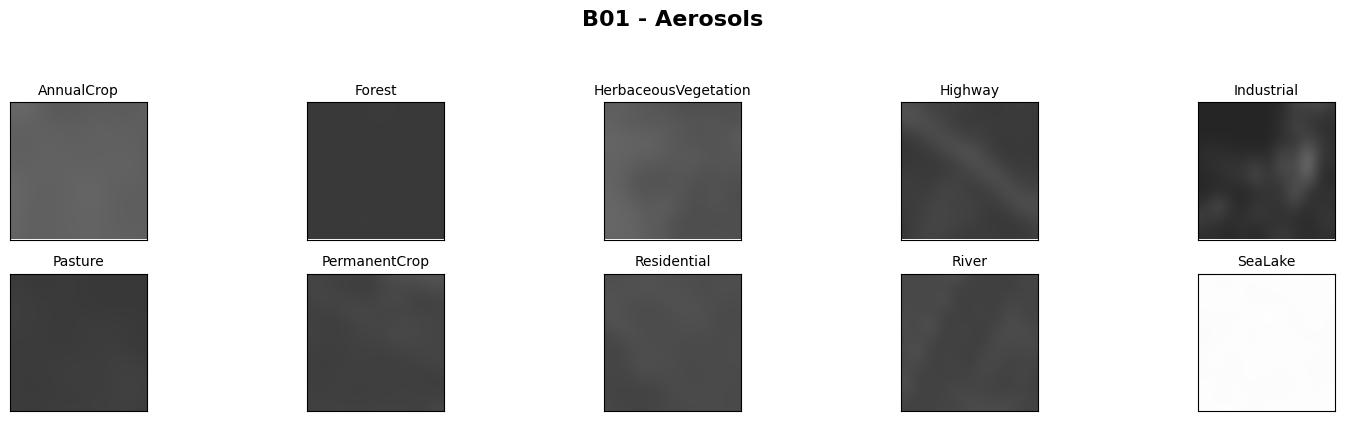

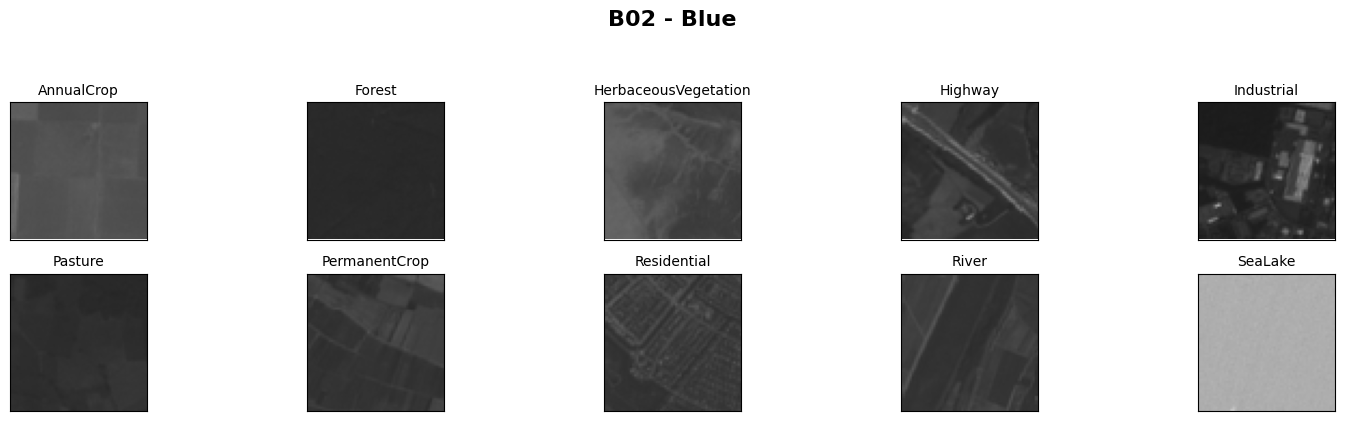

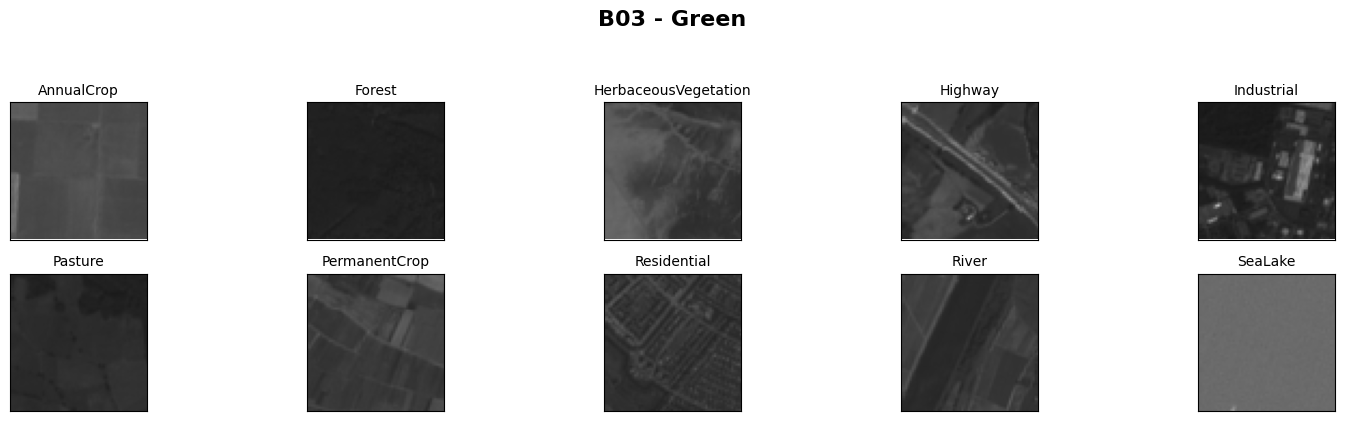

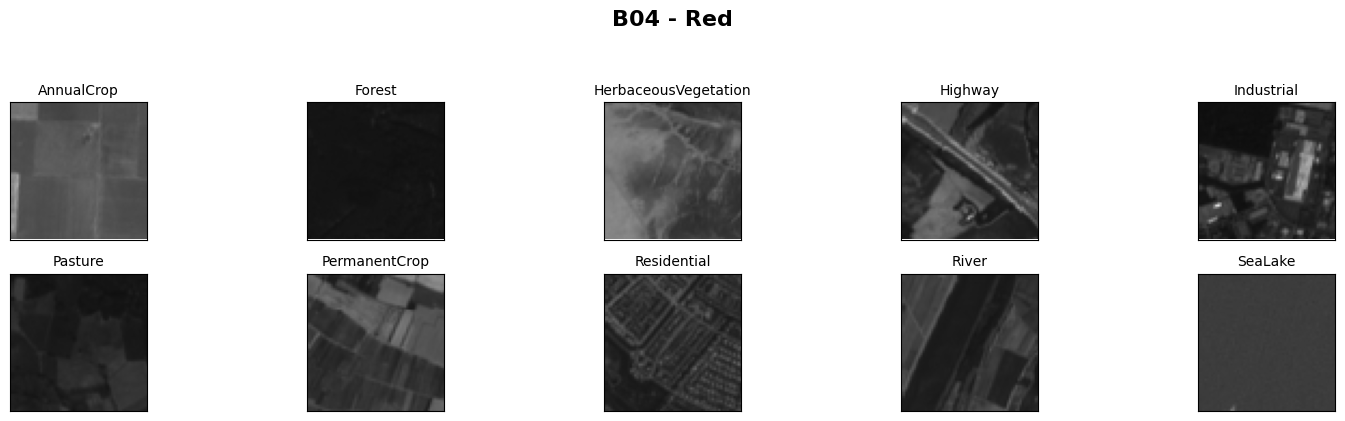

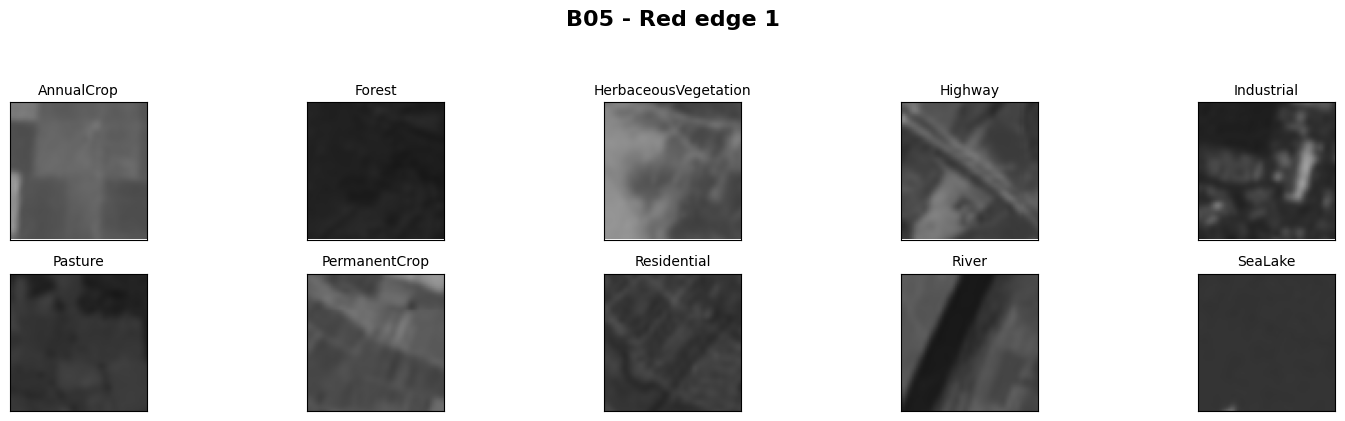

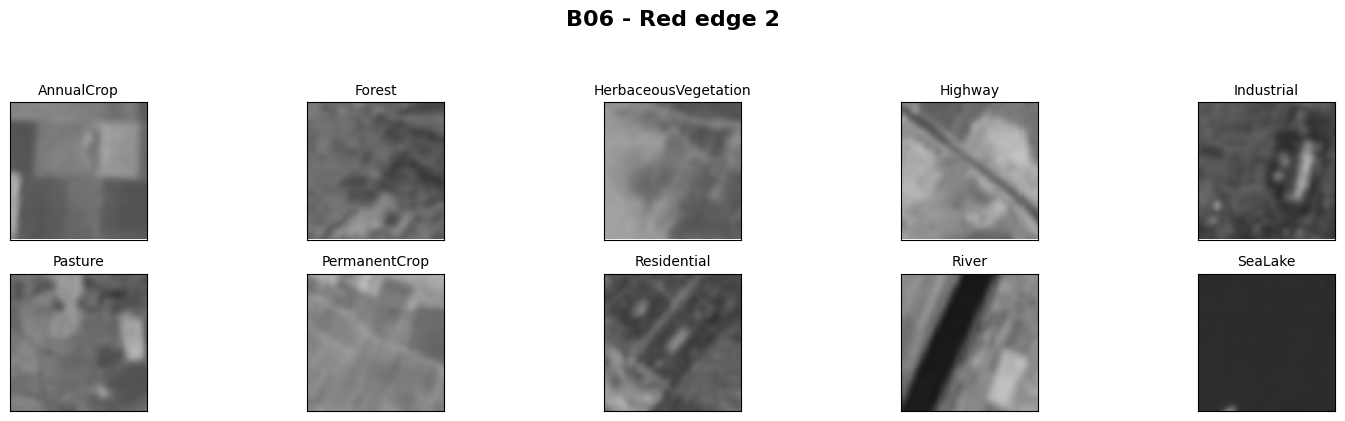

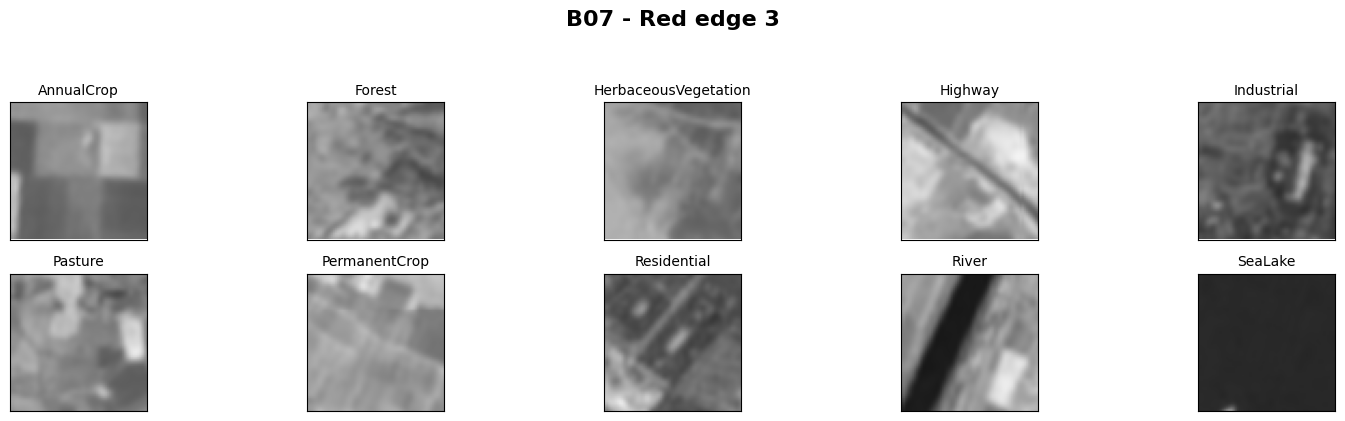

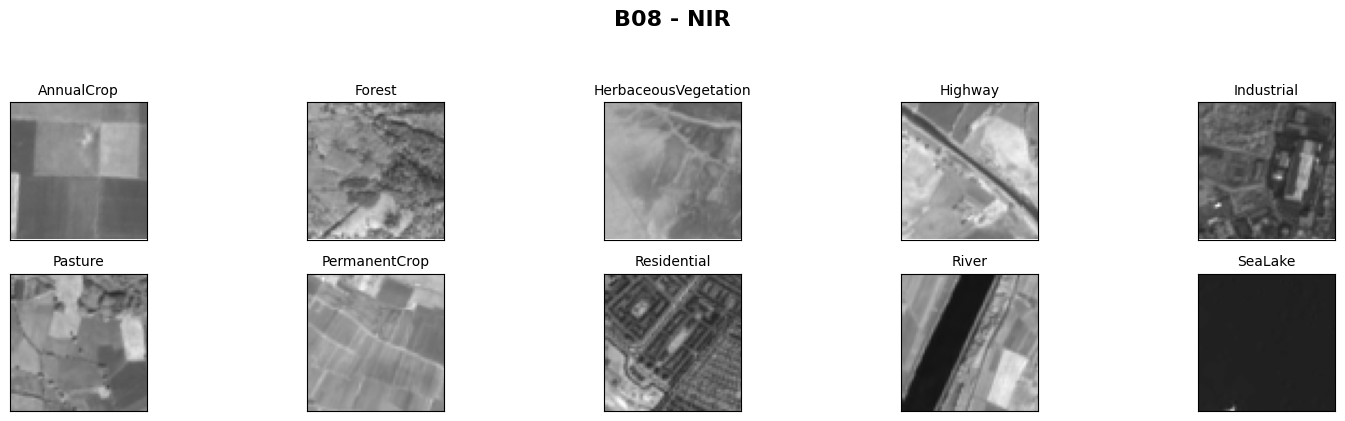

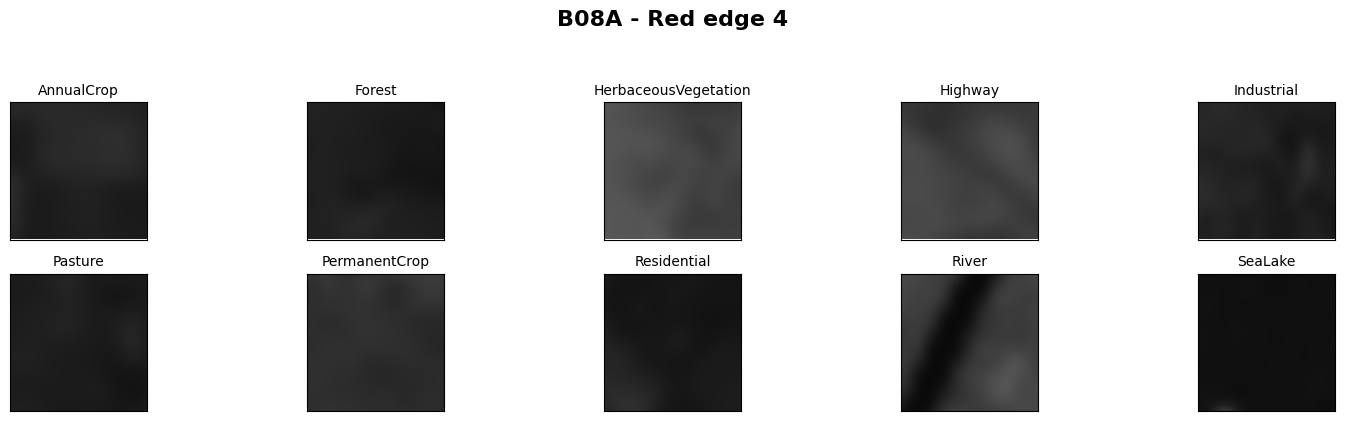

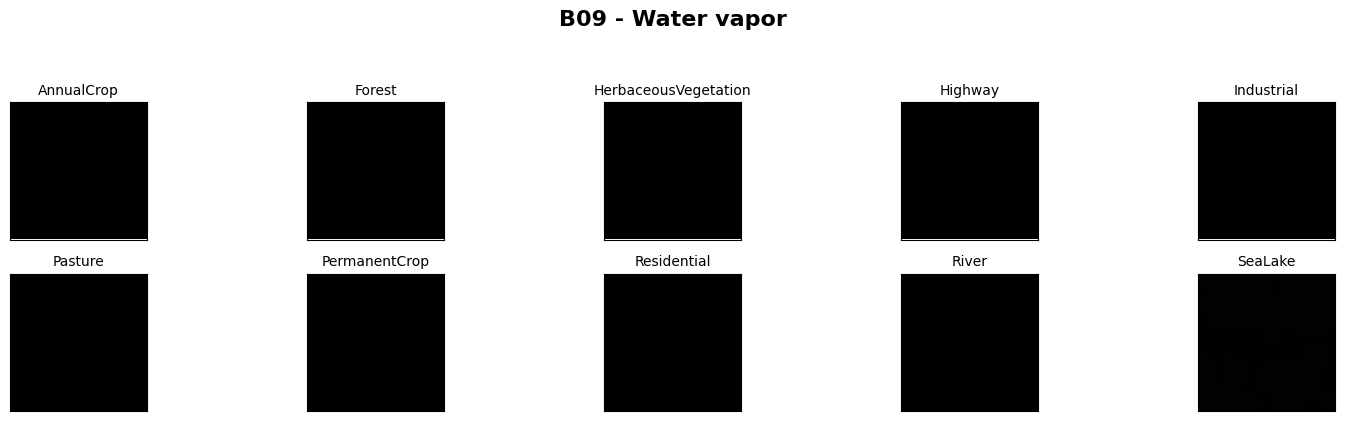

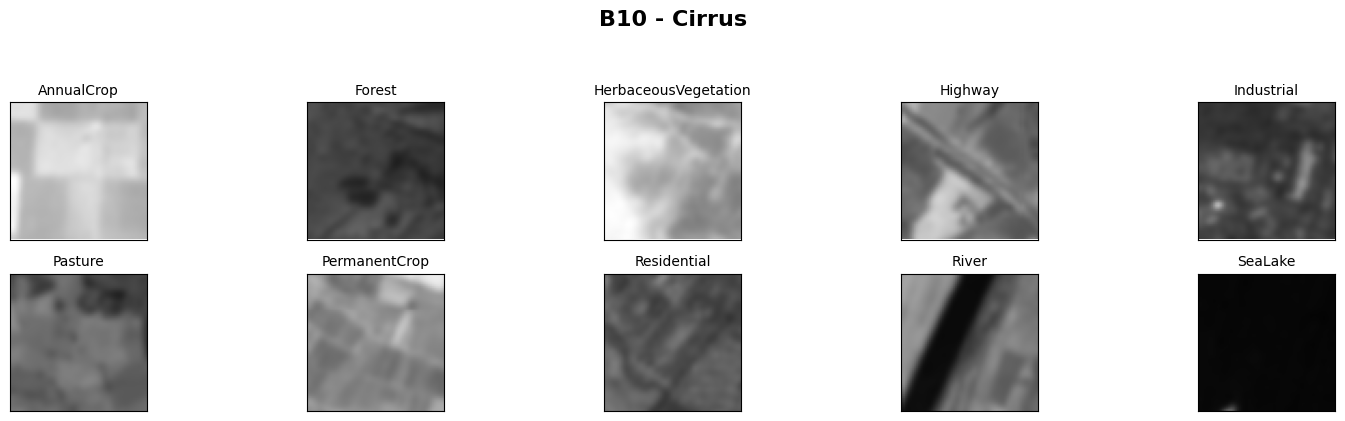

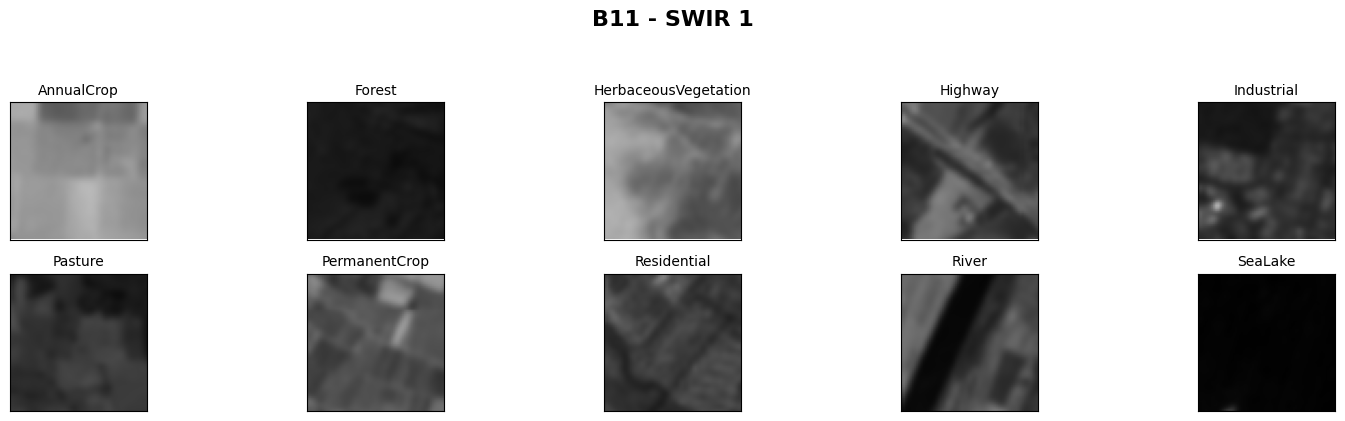

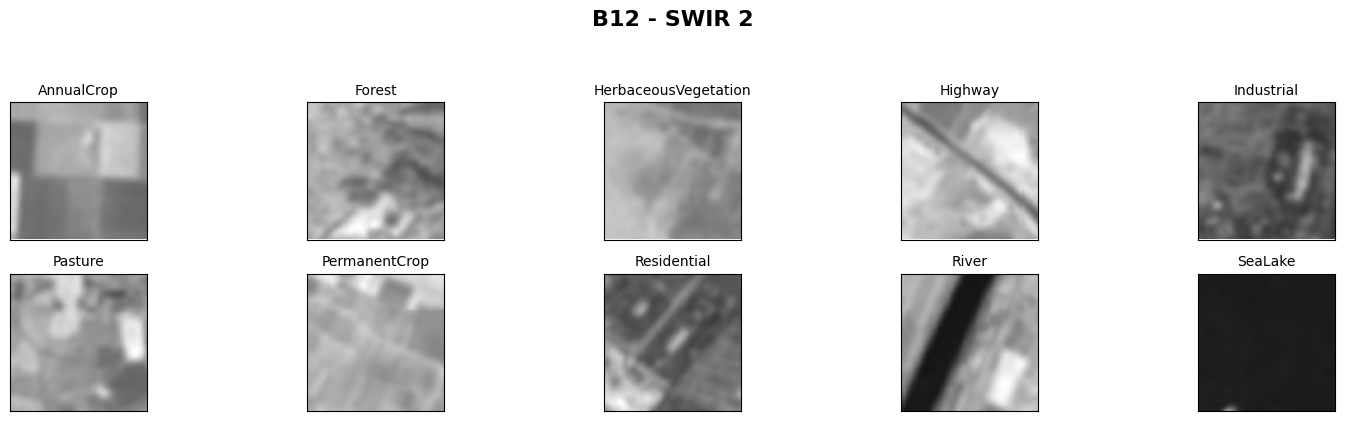

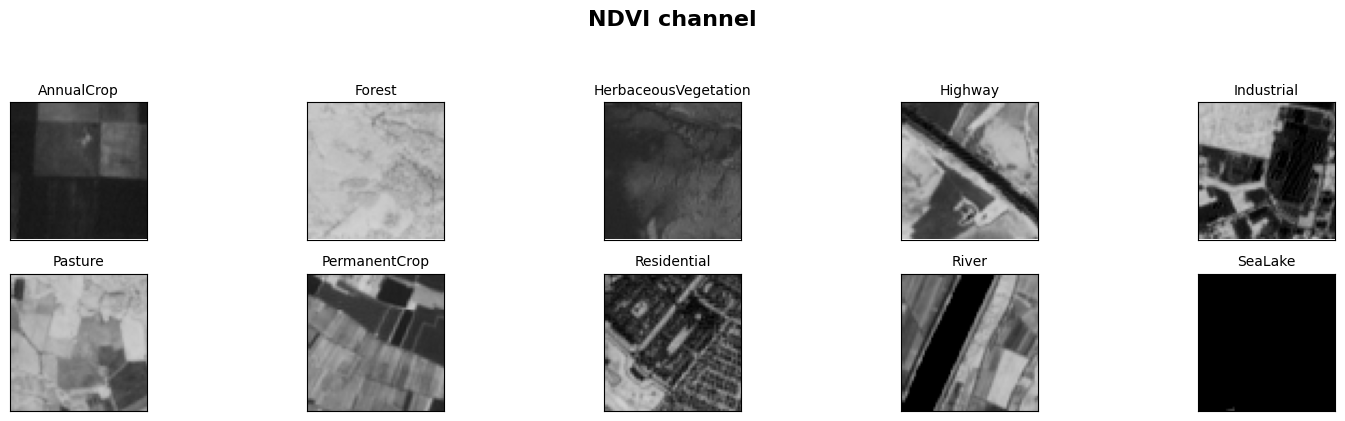

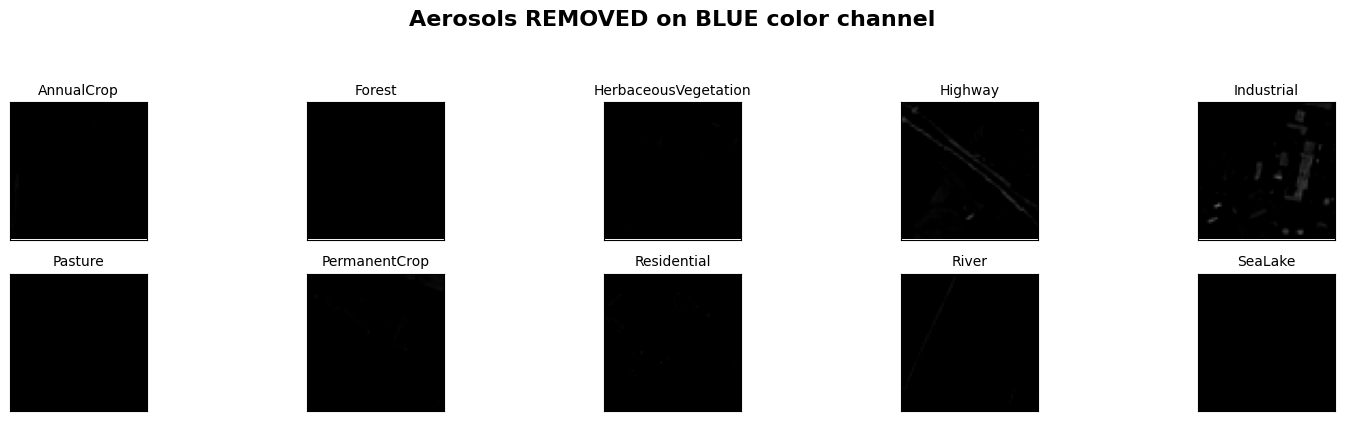

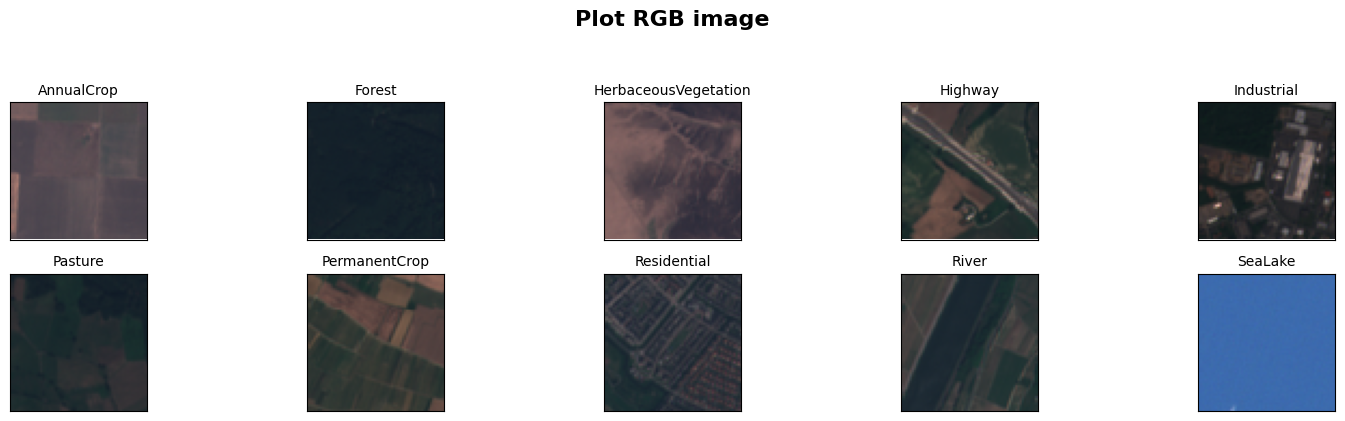

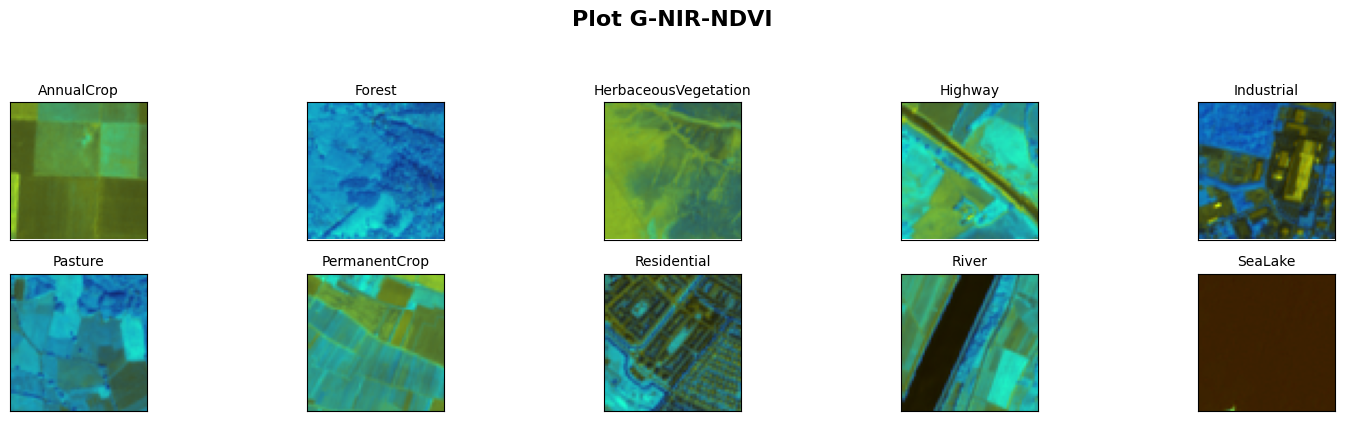

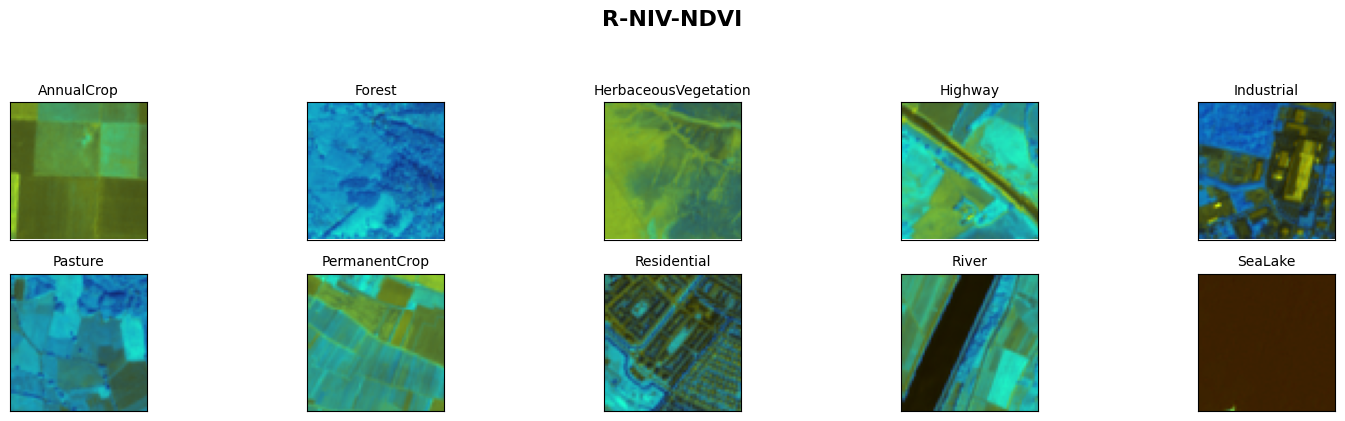

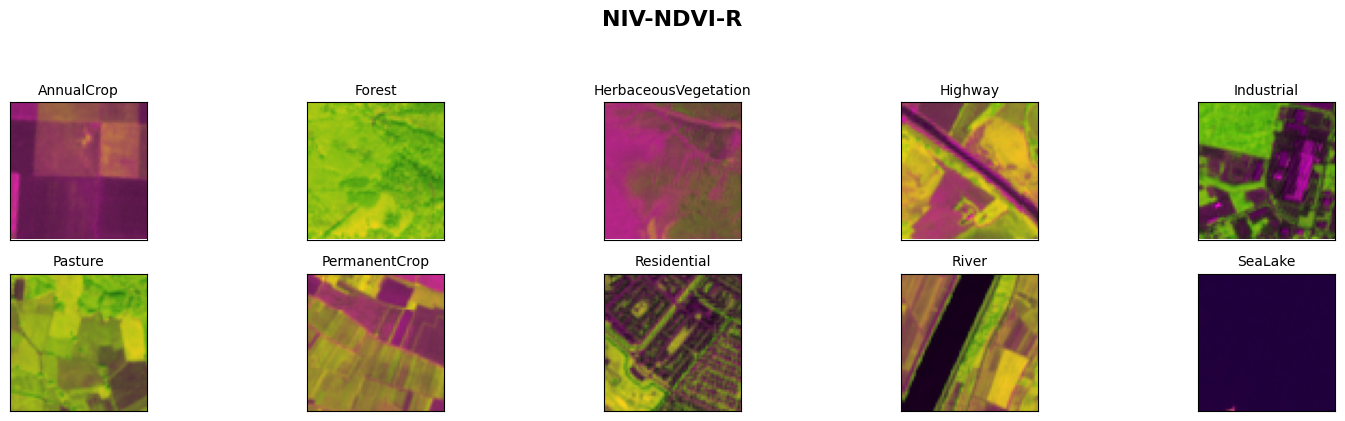

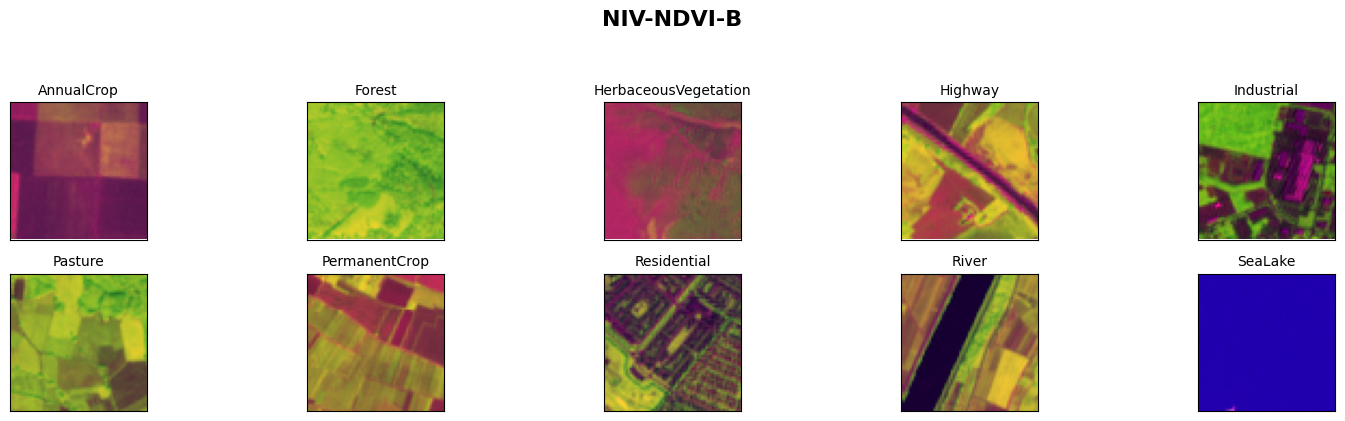

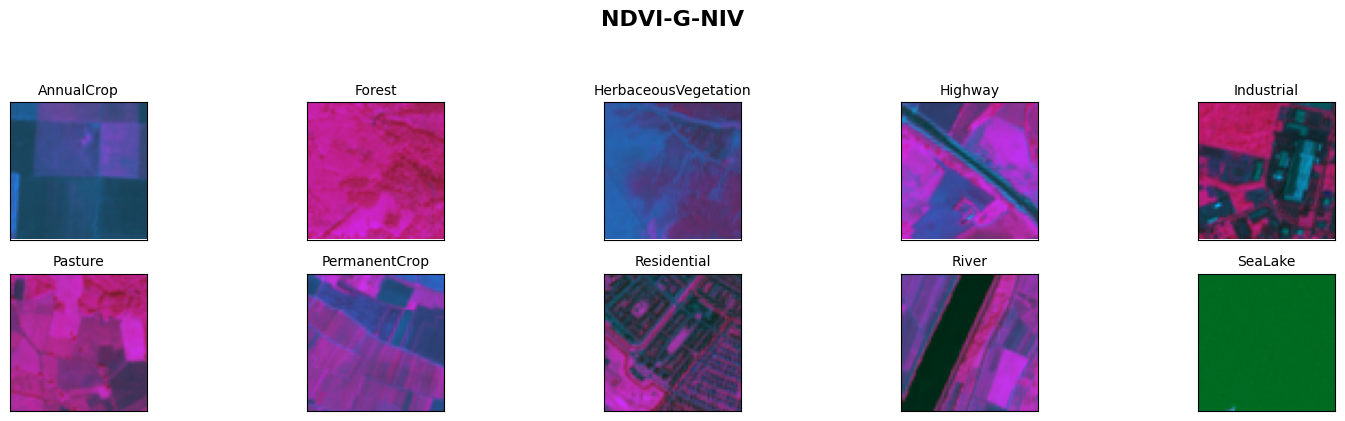

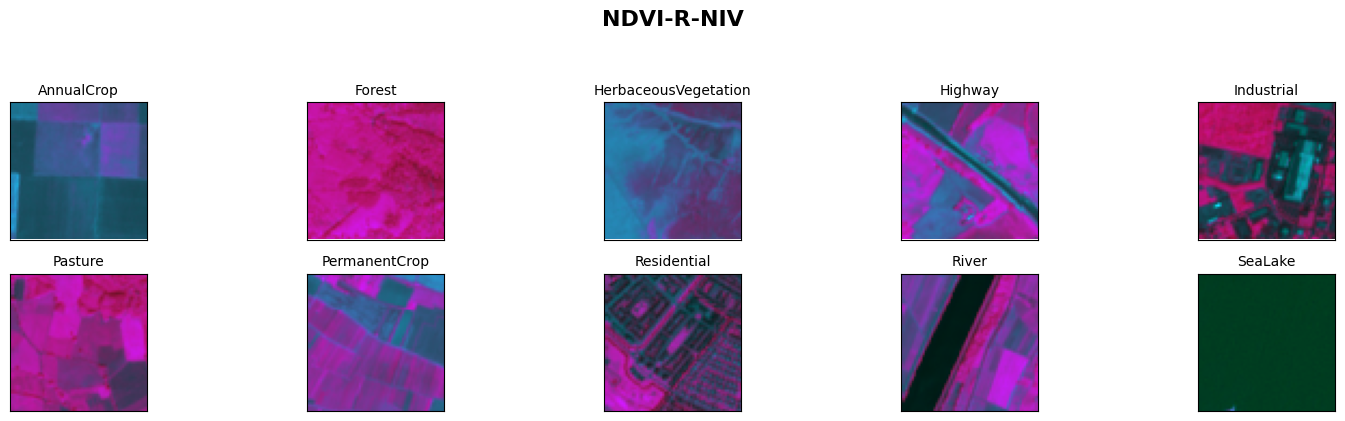

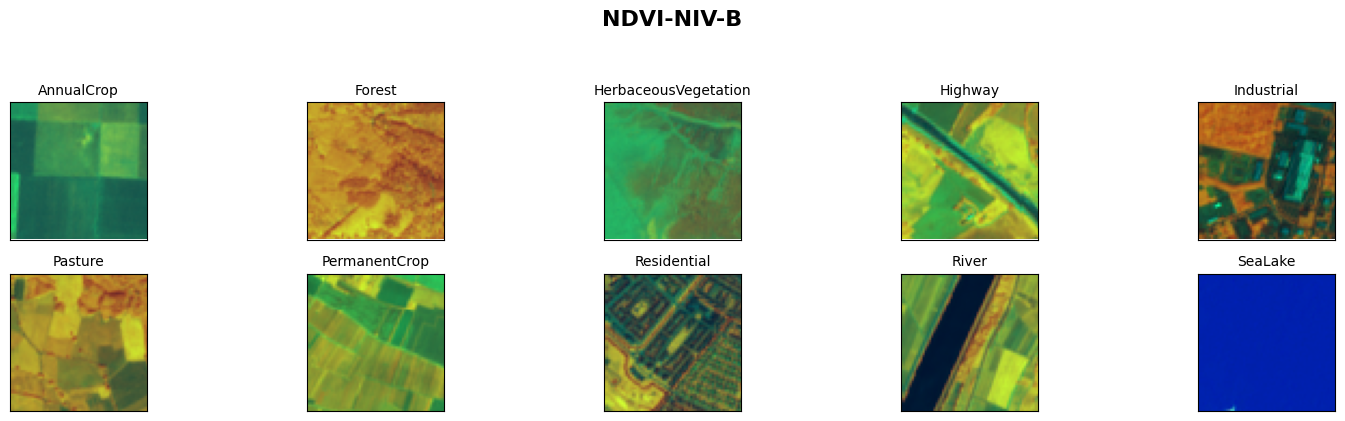

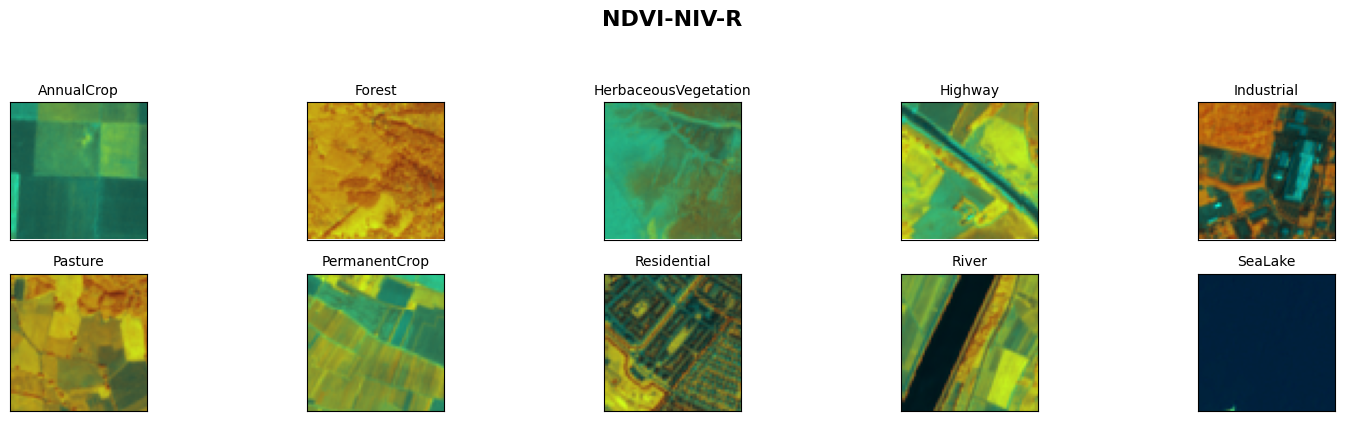

In [37]:
"""
To get a better understanding of the images,
plot for each class an image in different channel combinations.
"""

# Get all image paths for the first sample per class
img_paths = [os.path.join(EUROSAT_DIR, l, l+"_1.tif") for l in CLASSES]

# Load and process the images
images = []
for i, path in enumerate(img_paths):
    with rio.open(img_paths[i], "r") as d:
        # Read all bands
        img = d.read([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])
        
        # Reshape the image to the desired form (64x64x13)
        img = np.moveaxis(img,0,2)
        
        # Clip values for display the images
        img = np.clip(img / np.max(img), 0, 1)
        
        # Calculate NDVI
        nir_band = img[:,:,7]  # NIR band (index 7)
        red_band = img[:,:,3]  # Red band (index 3)
        denominator = nir_band + red_band
        denominator[denominator == 0] = 1  # Avoid division by zero
        ndvi = (nir_band - red_band) / denominator
        ndvi_reshaped = ndvi.reshape(img.shape[0], img.shape[1], 1)
        img = np.concatenate((img, ndvi_reshaped), axis=2)
    
        # For all RGB channels remove aerosol channel
        blue_aerosols_removed = img[:,:,1] - img[:,:,0]
        green_aerosols_removed = img[:,:,2] - img[:,:,0]
        red_aerosols_removed = img[:,:,3] - img[:,:,0]
        
        # BLUE - without Aerosols
        blue_aerosols_removed_reshaped = blue_aerosols_removed.reshape(img.shape[0], img.shape[1], 1)
        img = np.concatenate((img, blue_aerosols_removed_reshaped), axis=2)
        
        # GREEN - without Aerosols
        green_aerosols_removed_reshaped = green_aerosols_removed.reshape(img.shape[0], img.shape[1], 1)
        img = np.concatenate((img, green_aerosols_removed_reshaped), axis=2)
        
        # RED - without Aerosols
        red_aerosols_removed_reshaped = red_aerosols_removed.reshape(img.shape[0], img.shape[1], 1)
        img = np.concatenate((img, red_aerosols_removed_reshaped), axis=2)
    
        # Clip again
        img = np.clip(img / np.max(img), 0, 1)
        
        images.append(img)


def plot_images_by_channel(paths, channels, title=None):
    """Plot images for a given channel combination.
    
    Keyword arguments:
    paths -- all paths to the images
    channels -- channel combination
    title -- the title of the plot"""
    
    plt.figure(figsize=(15, 8))
    for i in range(len(paths)):
        plt.subplot(4, 5, i+1, xticks=[], yticks=[])
        plt.imshow(images[i][:, :, channels])
        plt.title(paths[i].split('/')[-2], fontsize=10)
        
    if title:
        plt.suptitle(title, fontsize=16, fontweight="bold")
        
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


# Plot all bands in grayscale
# B01 - Aerosols
plot_images_by_channel(img_paths, [0,0,0], title="B01 - Aerosols")

# B02 - Blue
plot_images_by_channel(img_paths, [1,1,1], title="B02 - Blue")

# B03 - Green
plot_images_by_channel(img_paths, [2,2,2], title="B03 - Green")

# B04 - Red
plot_images_by_channel(img_paths, [3,3,3], title="B04 - Red")

# B05 - Red edge 1
plot_images_by_channel(img_paths, [4,4,4], title="B05 - Red edge 1")

# B06 - Red edge 2
plot_images_by_channel(img_paths, [5,5,5], title="B06 - Red edge 2")

# B07 - Red edge 3
plot_images_by_channel(img_paths, [6,6,6], title="B07 - Red edge 3")

# B08 - NIR
plot_images_by_channel(img_paths, [7,7,7], title="B08 - NIR")

# B08A - Red edge 4
plot_images_by_channel(img_paths, [8,8,8], title="B08A - Red edge 4")

# B09 - Water vapor
plot_images_by_channel(img_paths, [9,9,9], title="B09 - Water vapor")

# B10 - Cirrus
plot_images_by_channel(img_paths, [10,10,10], title="B10 - Cirrus")

# B11 - SWIR 1
plot_images_by_channel(img_paths, [11,11,11], title="B11 - SWIR 1")

# B12 - SWIR 2
plot_images_by_channel(img_paths, [12,12,12], title="B12 - SWIR 2")

# NDVI channel
plot_images_by_channel(img_paths, [13,13,13], title="NDVI channel")

# Aerosols REMOVED on BLUE color channel
plot_images_by_channel(img_paths, [14,14,14], title="Aerosols REMOVED on BLUE color channel")

# Plot RGB image
plot_images_by_channel(img_paths, [3,2,1], title="Plot RGB image")

# Plot G-NIR-NDVI
plot_images_by_channel(img_paths, [3,7,13], title="Plot G-NIR-NDVI")

# Some other combinations
plot_images_by_channel(img_paths, [3,7,13], title="R-NIV-NDVI")
plot_images_by_channel(img_paths, [7,13,3], title="NIV-NDVI-R")
plot_images_by_channel(img_paths, [7,13,1], title="NIV-NDVI-B")
plot_images_by_channel(img_paths, [13,2,7], title="NDVI-G-NIV")
plot_images_by_channel(img_paths, [13,3,7], title="NDVI-R-NIV")
plot_images_by_channel(img_paths, [13,7,1], title="NDVI-NIV-B")
plot_images_by_channel(img_paths, [13,7,3], title="NDVI-NIV-R")

# **Data Preprocessing**

In [38]:
def load_and_process_data(paths):
    """Load and process all images provided by the 'paths' argument.
  
    Keyword arguments:
    paths -- all image paths
    """
    
    temp_list = []
    data = np.empty((0, 64, 64, 14), dtype = np.float16)
    labels = np.array([])

    for i, path in enumerate(paths):
        label = path.split("/")[-1].split("_")[0]
        label_index = CLASSES.index(label)
        labels = np.append(labels, label_index)
    
        with rio.open(path, "r") as d:      
            # Read all bands
            img = d.read([1,2,3,4,5,6,7,8,9,10,11,12,13])

        # Reshape the images to have the form 64x64x12
        img = np.moveaxis(img, 0, 2)

        # Compute NDVI index
        denominator = img[:,:,7] + img[:,:,3]
        denominator[denominator == 0] = 1
        ndvi = np.array((img[:,:,7] - img[:,:,3]) / denominator)
        img = np.append(img, ndvi.reshape(WIDTH,WIDTH,1), axis=2)

        temp_list.append(img)

        # To speed up the processing of all images, save a batch of data in a list,
        # then after a batch, append them to the np-array 'data'
        if (i+1) % 1000 == 0: 
          data = np.append(data, np.array(temp_list, dtype = np.float16), axis = 0)
          temp_list = []

    return data, labels

# Start load and process data
data, labels = load_and_process_data(train_samples)

In [39]:
def normalize_data(images):
    """Normalize the provided images.
  
    Keyword arguments:
    images -- to be normalized (each band separately)
    """
    images[np.isnan(images)] = 0

    band_mean = np.mean(images, axis = (0,1,2), dtype = np.float64).astype("float16")
    band_std = np.std(images, axis = (0,1,2), dtype = np.float64).astype("float16")

    # Normalize each band separately
    for i in range(len(band_mean)): 
        images[:,:,:,i]=(images[:,:,:,i]-band_mean[i])/band_std[i]
    
    # We only select 3 bands for model training: Red (3), Green (2), and NDVI (12)
    return images[:,:,:,[7,2,13]]

# Start normalizing the data
data = normalize_data(data)

In [40]:
def data_augmentation(data, labels):
    """Augment the provided data.
    
    1. Randomly rotate or flip the image
    2. Randomly eliminate pixel patches of size 12x12
  
    Keyword arguments:
    data -- to be augmented
    labels -- associated with the data

    https://github.com/Sesatt/EuroSAT-satellite-image-classification
    """

    N = len(labels)
    adj_data = []

    # Choose random images for augmentation
    augmentation_size = round(AUGMENTATION_PERCENTAGE*N)
    rotate_idx = np.random.choice(N, size = augmentation_size, replace = False)
    eliminate_idx = np.random.choice(N, size = augmentation_size, replace = False)

    # 1. Randomly rotate or flip the image
    for i in range(N):
        img = data[i]
        label_no = labels[i]
        if i in rotate_idx:            
            rand = np.random.randint(3, size = 1)
            if rand == 0:
                img_adj1 = np.flipud(img)
            elif rand == 1:
                img_adj1 = np.fliplr(img)
            elif rand == 2:
                img_adj1 = np.rot90(img, 1, [0,1])
            labels = np.append(labels,label_no)
            adj_data.append(img_adj1)
        
    # 2. Randomly eliminate pixel patches of size 12x12
    if i in eliminate_idx:
        q=64
        P=q*q
        ps=12
        
        IDX = np.random.randint(P)
        x0, y0 = np.unravel_index(IDX,(q,q))
        x, y, x1, y1 = x0, y0, x0 + ps, y0 + ps
        
        img[x:x1, y:y1,:] = 0.0
        img_adj2 = img
        
        labels = np.append(labels, label_no)
        adj_data.append(img_adj2)

    # To speed up the processing of all images, save a batch of data in a list,
    # then after a batch, append them to the np-array 'data'
    if (i+1) % 1000 == 0:
        data = np.append(data, np.array(adj_data, dtype = np.float16), axis = 0)
        adj_data = []

    return data, labels

data, labels = data_augmentation(data, labels)

# **Preparing Test/Train Split**

In [41]:
def randomize_order(data, labels):
    """Randomizes the order of the dataset.
    
    Keyword arguments:
    data -- the data that needs to be randomized
    labels -- the corresponding labels of the to be randomized data
    """
    
    total_count = len(labels)
    index = np.random.choice(total_count, size=total_count, replace=False)
    data = data[index]
    labels = labels[index]
    
    return data, labels

In [42]:
def create_train_test_split(data, labels):
    """Creates the train- and test split of the dataset by the 
    specified split percentage. Note that we transform the labels here into one-hot encoding
    for our training phase.
    
    Keyword arguments:
    data -- data to be split
    labels -- corresponding labels to be split
    """
    
    data, labels = randomize_order(data, labels)
    
    test_size = int(SPLIT_PERCENTAGE * len(data))
    testset_idx = np.random.choice(len(data), size = test_size, replace = False)

    input_test = data[testset_idx]
    target_test = labels[testset_idx]
    target_test_tensor = torch.from_numpy(target_test).long()
    target_test_one_hot = torch.nn.functional.one_hot(target_test_tensor, num_classes=10)
  
    input_train = np.delete(data, testset_idx, axis = 0)
    target_train = np.delete(labels, testset_idx, axis = 0)
    target_train_tensor = torch.from_numpy(target_train).long()
    target_train_one_hot = torch.nn.functional.one_hot(target_train_tensor, num_classes=10)

    return torch.from_numpy(input_train), target_train_one_hot, torch.from_numpy(input_test), target_test_one_hot

In [43]:
# Creating the train- and test split of the data
train_data, train_labels, test_data, test_labels = create_train_test_split(data, labels)

print(f"Found {train_data.shape[0]} train samples.")
print(f"Found {test_data.shape[0]} test samples.")

Found 24570 train samples.
Found 10530 test samples.


# **Model Training**
The initial model training uses ResNet50V2 with pre-trained imagenet weights, freezes the layers, and trains with a moderate learning rate. Later, the end-to-end training will unfreeze the layers and train the whole model by keeping a small learning rate.

In [92]:
def compile_model(input_shape, n_classes, optimizer, fine_tune=None):
    """Compile the ResNet50V2 model.

    Keyword arguments:
    input_shape -- the expected shape of the model input, like 64x64x3
    n_classes -- the number of possible classes for classification
    optimizer -- the optimizer to be used by the model, like Adam
    fine_tune -- starting from which layer the layers should be trainable. Pass 0 to train all layers
    """

    # use model pre-trained with imagenet weights
    conv_base = ResNet50V2(include_top=False,
                           weights='imagenet', 
                           input_shape=input_shape)
    
    # Add a Dense layer to be trained. Output layer has n_classes number of classes
    top_model = conv_base.output
    top_model = Flatten()(top_model)
    top_model = Dense(2048, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)    
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    model = Model(inputs=conv_base.input, outputs=output_layer)
        
    # Whether the layers should be trainable.
    # Set to false for initial training and set to true for end-to-end training (as we want to train all layers)
    if type(fine_tune) == int:
        for layer in conv_base.layers[fine_tune:]:
            layer.trainable = True
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    model.compile(optimizer=optimizer, loss='categorical_crossentropy',
                  metrics=['categorical_accuracy'])
    
    return model

In [93]:
resnet50V2_model = compile_model(INPUT_SHAPE, len(CLASSES), Adam(learning_rate=LEARNINGRATE), fine_tune=None)

In [94]:
# Load data and create a train/test split via the train_test function
train_data, train_labels, test_data, test_labels = create_train_test_split(data, labels)
train_dataset = torch.utils.data.TensorDataset(train_data, train_labels)
test_dataset = torch.utils.data.TensorDataset(test_data, test_labels)

train_generator = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_generator = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

N_STEPS = len(train_dataset) // BATCH_SIZE
N_VAL_STEPS = len(train_dataset) // BATCH_SIZE

# Train the model for the specified number of epochs
resnet50V2_history = resnet50V2_model.fit(train_generator,
                     steps_per_epoch=N_STEPS,
                     epochs=EPOCHS,
                     validation_data=test_generator,
                     validation_steps=N_VAL_STEPS)

# Store the trained weights for later use in end-to-end training
resnet50V2_model.save('./model.h5')

Epoch 1/4
  7/767 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - categorical_accuracy: 0.3416 - loss: 5.7423 

W0000 00:00:1715540231.485113     292 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


767/767 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - categorical_accuracy: 0.7651 - loss: 1.7395

W0000 00:00:1715540247.530331     291 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


767/767 ━━━━━━━━━━━━━━━━━━━━ 32s 28ms/step - categorical_accuracy: 0.7651 - loss: 1.7385 - val_categorical_accuracy: 0.8500 - val_loss: 0.5194
Epoch 2/4


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


767/767 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - categorical_accuracy: 0.9615 - loss: 0.2948 - val_categorical_accuracy: 0.8512 - val_loss: 0.5148
Epoch 3/4
767/767 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - categorical_accuracy: 0.8804 - loss: 0.4216 - val_categorical_accuracy: 0.8598 - val_loss: 0.5075
Epoch 4/4
767/767 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - categorical_accuracy: 0.9231 - loss: 0.1711 - val_categorical_accuracy: 0.8580 - val_loss: 0.5154


# **Model Accuracy and Loss Over Epochs (Before End-to-End Training)**

In [95]:
def plot_history(history):
    """Plot the history of a model prediction.

    Keyword arguments:
    history -- the history of model predictions
    """ 
    
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(acc)
    plt.plot(val_acc)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.title('Accuracy Over Epochs')
    
    plt.subplot(1, 2, 2)
    plt.plot(loss)
    plt.plot(val_loss)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.title('Loss Over Epochs')
    
    plt.show();

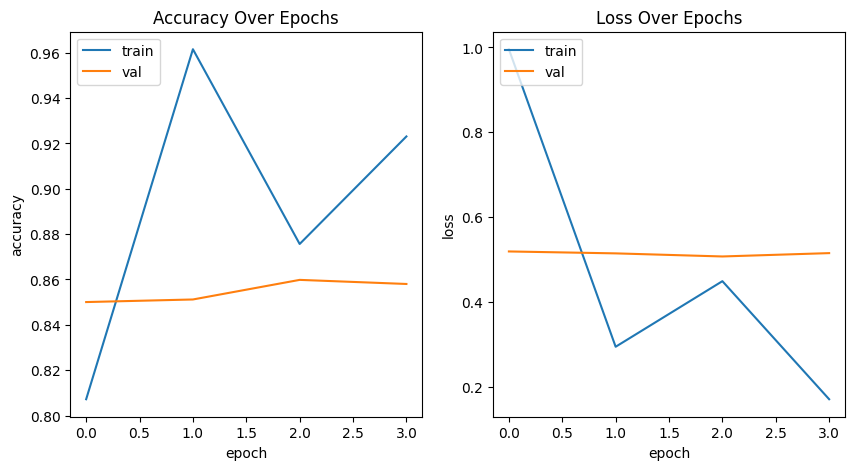

In [96]:
plot_history(resnet50V2_history)

# **End2End Training**
After the initial training, we unfreeze all layers and fine-tune the whole model end-to-end by keeping a small learning rate.

In [97]:
# Load the model with a lower learning rate and load the trained weights after the initial training
resnet50V2_model = compile_model(INPUT_SHAPE, len(CLASSES), Adam(learning_rate=LEARNINGRATE_E2E), fine_tune=0)
resnet50V2_model.load_weights('./model.h5')

In [98]:
# Load data and create a train/test split via the train_test function
train_data, train_labels, test_data, test_labels = create_train_test_split(data, labels)
train_dataset = torch.utils.data.TensorDataset(train_data, train_labels)
test_dataset = torch.utils.data.TensorDataset(test_data, test_labels)

train_generator = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_generator = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [99]:
# During end-to-end training, only store the new weights if they have better val accuracy
checkpoint = ModelCheckpoint(filepath='./model.weights.best.keras',
                          monitor='val_categorical_accuracy',
                          save_best_only=True,
                          verbose=1)
# Stop training when monitored metric has stopped improving
early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='max')
# Reduce the laerning rate when a plateau is reached
reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=3, min_lr=0.00001)

N_STEPS = len(train_dataset) // BATCH_SIZE
N_VAL_STEPS = len(train_dataset) // BATCH_SIZE

# Train the model end-to-end for the specified number of epochs
resnet50V2_e2e_history = resnet50V2_model.fit(train_generator,
                     steps_per_epoch=N_STEPS,
                     epochs=EPOCHS_E2E,
                     callbacks=[early_stop, checkpoint, reduce_lr],
                     validation_data=test_generator,
                     validation_steps=N_VAL_STEPS)

Epoch 1/18
  2/767 ━━━━━━━━━━━━━━━━━━━━ 1:03 83ms/step - categorical_accuracy: 0.4531 - loss: 1.7422   

W0000 00:00:1715540333.477787     291 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


767/767 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - categorical_accuracy: 0.7982 - loss: 0.6323

W0000 00:00:1715540376.506667     292 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_categorical_accuracy improved from -inf to 0.93561, saving model to ./model.weights.best.keras
767/767 ━━━━━━━━━━━━━━━━━━━━ 100s 67ms/step - categorical_accuracy: 0.7983 - loss: 0.6320 - val_categorical_accuracy: 0.9356 - val_loss: 0.2000 - learning_rate: 1.0000e-04
Epoch 2/18
  1/767 ━━━━━━━━━━━━━━━━━━━━ 4:12:15 20s/step - categorical_accuracy: 0.8462 - loss: 0.3630
Epoch 2: val_categorical_accuracy improved from 0.93561 to 0.93618, saving model to ./model.weights.best.keras
767/767 ━━━━━━━━━━━━━━━━━━━━ 26s 8ms/step - categorical_accuracy: 0.8462 - loss: 0.3630 - val_categorical_accuracy: 0.9362 - val_loss: 0.2007 - learning_rate: 1.0000e-04
Epoch 3/18
767/767 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - categorical_accuracy: 0.9433 - loss: 0.1738
Epoch 3: val_categorical_accuracy improved from 0.93618 to 0.94463, saving model to ./model.weights.best.keras
767/767 ━━━━━━━━━━━━━━━━━━━━ 46s 60ms/step - categorical_accuracy: 0.9433 - loss: 0.1738 - val_categorical_accuracy: 0.9446 -

In [100]:
# Store the final model after training
resnet50V2_model.save('./model_end2end_trained.h5')

# **Model Accuracy and Loss Over Epochs (After End-to-End Training)**

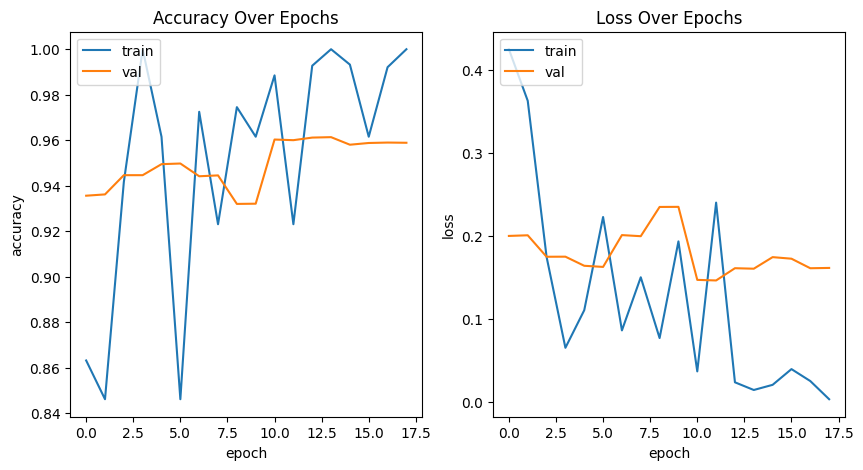

In [101]:
plot_history(resnet50V2_e2e_history)

# **Confusion Matrix of Predictions on Test Data**

 13/330 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step

W0000 00:00:1715540808.582634     292 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


330/330 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step
Number of predictions: 10530
Number of test labels:  10530


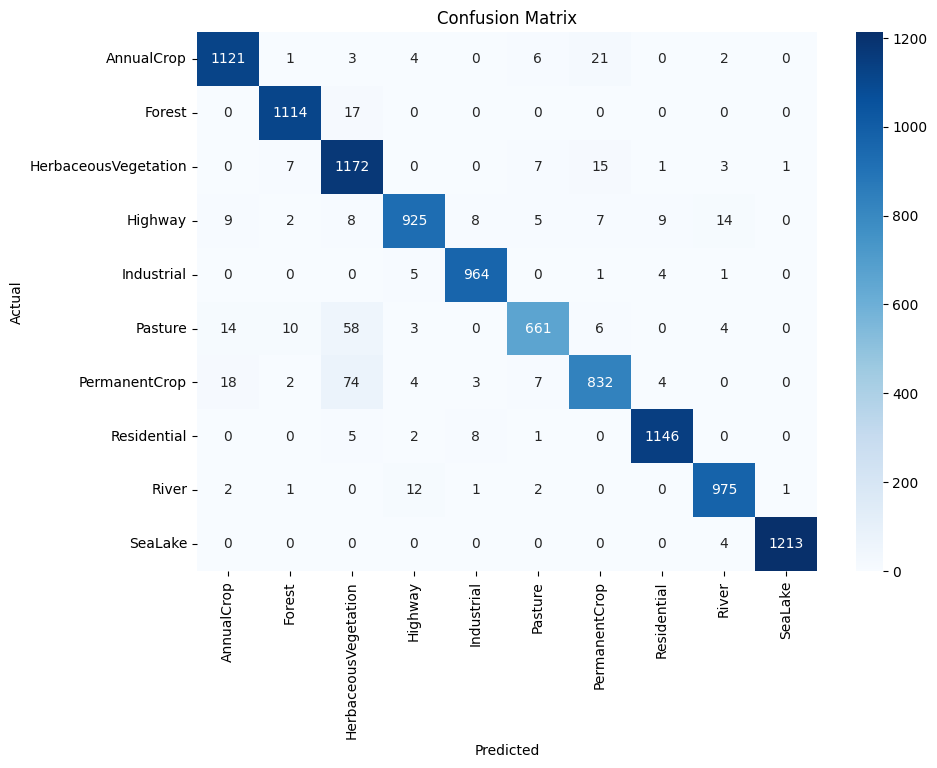

In [102]:
"""
The confusion matrix visualizes the accuracy of our classification model.
The 'Actual' label on the y-axis represents the true class labels,
and the 'Predicted' label on the x-axis represents the predicted class labels from the model.

The heatmap uses a blue color scheme, where a darker blue indicates a higher number of instances
in the cell. Darker blue cells along the diagonal indicate a higher number of correct predictions
for that class, which is desirable, and lighter shades in off-diagonal cells suggest fewer
misclassifications (good discriminatory ability) between different classes.
 
We see in our case, classes like 'Forest', 'HerbaceousVegetation', and 'Residential'
show high correct predictions (dark blue diagonal), suggesting strong model performance for these classes.
In difference to other classes like 'River' and 'SeaLake'  that have fewer instances or lower correct
prediction rates, as indicated by the lighter or zero cells.
"""

# Load the saved Keras model
model = load_model('./model_end2end_trained.h5')
 
# Predict using the loaded model
predictions = model.predict(test_data)
predicted_classes = np.argmax(predictions, axis=1)
 
# Verify the number of predictions matches the number of labels
print("Number of predictions:", len(predicted_classes))
print("Number of test labels: ", len(test_labels))
 
# Check if labels are one-hot encoded and convert if necessary
if test_labels.ndim > 1:
    test_labels = np.argmax(test_labels, axis=1)
 
# Compute the confusion matrix
if len(predicted_classes) == len(test_labels):
    cm = confusion_matrix(test_labels, predicted_classes)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=CLASSES, yticklabels=CLASSES)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
else:
    print("Mismatch in predicted classes and actual labels:", len(predicted_classes), len(test_labels))

# **Predicting Testset provided by Kaggle Challenge**

In [103]:
def create_testset(sample_paths):
    """
    Create and prepare the testset in the format ready to make predictions with our model.
    Loads all test samples, adds NDVI Index and normalizes data to match our training data preparation.

    Keyword arguments:
    sample_paths -- list of paths where samples are stored
    
    Output: 4D array of test data images (NxHxWxC); 1D array of test labels
    """
    
    test_data = []
    test_ids = []

    # loop through paths to load each test sample 
    for i in range(len(sample_paths)):
        sample = sample_paths[i]
        number = sample.split('/')[-1].split('_')[1].split('.')[0]
        img = np.load(sample)

        #add NDVI index
        denominator = img[:,:,7] + img[:,:,3]
        denominator[denominator == 0] = 1
        ndvi = np.array((img[:,:,7] - img[:,:,3]) / denominator)
        # append a dummy channel
        img = np.append(img, ndvi.reshape(WIDTH,HEIGHT,1), axis = 2)
        # append the NDVI channel
        img = np.append(img, ndvi.reshape(WIDTH,HEIGHT,1), axis = 2)

        test_ids.append(number)
        test_data.append(np.array(img))

    test_data = np.array(test_data)
    test_ids = np.array(test_ids)
    test_data = normalize_data(test_data)

    return test_data, test_ids


#create official testset
official_test_data, official_test_id = create_testset(official_test_samples)

In [104]:
def predict_testset(official_test_data):
    """
    Make predictions of provided testset using trained model.

    Keyword arguments:
    official_test_data -- the test data to predict on
    
    Output: an array of all predictions 
    """ 
    
    predictions = []

    for i, image in enumerate(official_test_data):
        if len(image.shape) == 3:
            image = np.expand_dims(image, axis=0)
        with contextlib.redirect_stdout(open(os.devnull, 'w')):
            pred = resnet50V2_model.predict(image)
        predictions.append(pred)
    
    return predictions


# Load the best trained weights into the model to start predicting
resnet50V2_model.load_weights("./model.weights.best.keras")

# Make predictions
predictions = predict_testset(official_test_data)
print("\nTotal predictions: {}".format(len(predictions)))

#Prepare predicted classes using argmax (ie. which class was determined to be the most likely)
predictions = np.concatenate(predictions, axis=0)
predicted_classes = np.argmax(predictions, axis=1)


Total predictions: 4232


In [105]:
def create_df_output(predictions, test_ids):
    """
    Create a dataframe of the predictions

    Keyword arguments:
    predictions -- the predictions for all test ids
    test_ids -- the test ids associated with the predictions
    
    Output: a dataframe holding the test_ids with associated predictions (classes)
    """ 
    output = {}
    for i in range(len(predictions)):
        no = test_ids[i]
        output[no] = CLASSES[predictions[i]]
    df = pd.DataFrame(output.items(), columns = ["test_id", "label"])
    
    return df

# Create a dataframe of the resulting predictions
result_df = create_df_output(predicted_classes, official_test_id)
print(result_df.label.value_counts()) # Return the distribution of classified labels for a quick overview

label
SeaLake                 1034
PermanentCrop            757
HerbaceousVegetation     715
Highway                  360
Industrial               291
Pasture                  282
Residential              254
AnnualCrop               200
River                    173
Forest                   166
Name: count, dtype: int64


In [106]:
# Create a submission.csv file to submit in the challenge
result_df.to_csv("submission.csv", index = False)